In [5]:
!pip install fooof
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.signal import welch
from fooof import FOOOF
from scipy.interpolate import interp1d
from tqdm import tqdm
import seaborn as sns
from scipy.stats import friedmanchisquare
import pandas as pd

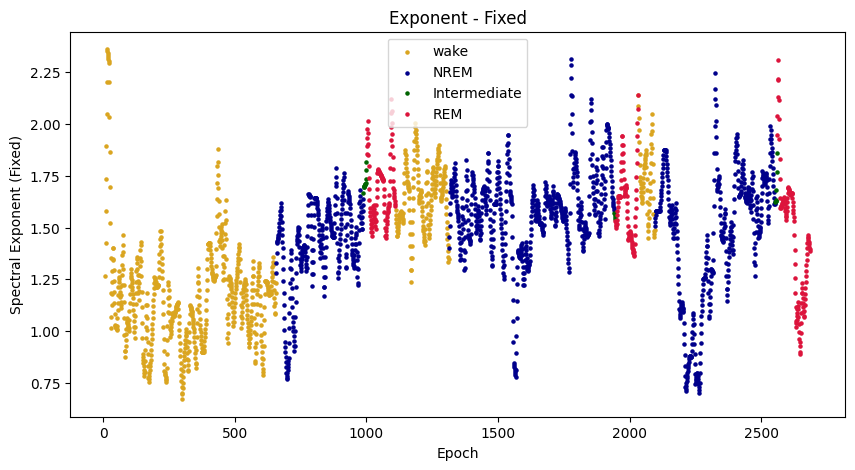

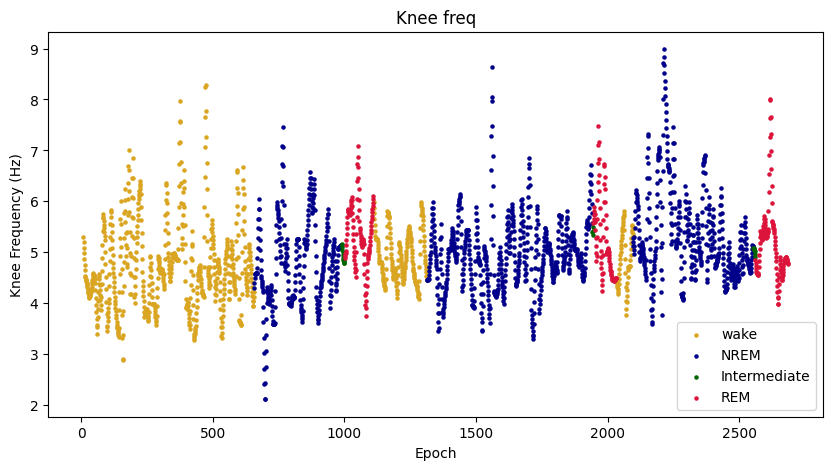

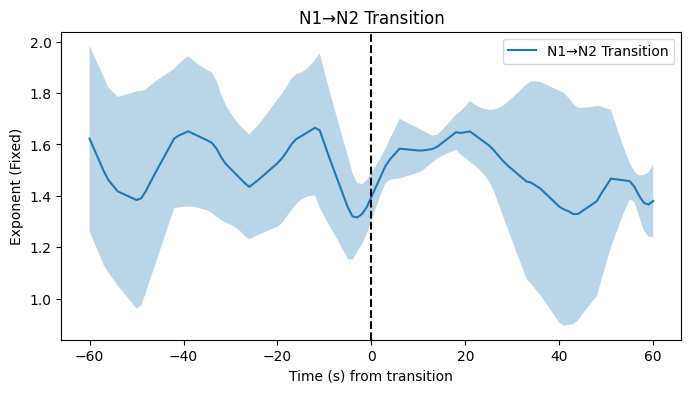

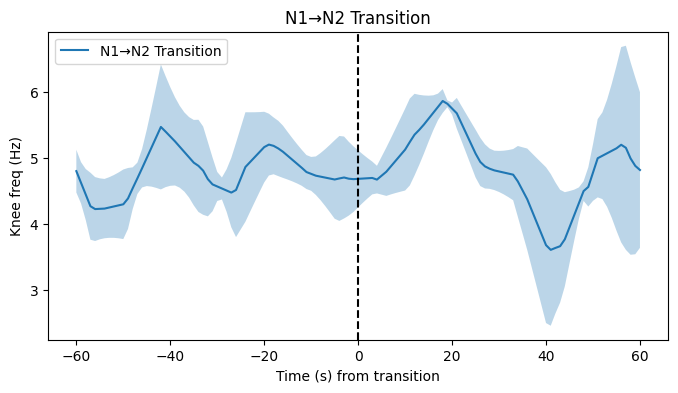

No valid transitions for NREM→REM Transition
No valid transitions for NREM→REM Transition


In [11]:


# SETTINGS
fs = 2500  # Hz
win_sec = 15
overlap = 0.5
f_range = [1, 45]
max_n_peaks = 8
epoch_sec = 1
win_samp = int(win_sec * fs)
step_samp = int(win_samp * (1 - overlap))

# LOAD DATA
mat = loadmat('/content/HPC_100_CH18_0.continuous.mat')
signal = mat['HPC'].squeeze()

stage_mat = loadmat('/content/2021-06-18_13-09-53_posttrial4-states_SM.mat')
stages = stage_mat['states'].squeeze()

# FOOOF SLIDING WINDOWS
n_win = (len(signal) - win_samp) // step_samp
exps_fixed, exps_knee, knees, times = [], [], [], []

for i in range(n_win):
    start = i * step_samp
    seg = signal[start:start+win_samp]
    freqs, psd = welch(seg, fs=fs, nperseg=win_samp)
    mask = (freqs >= f_range[0]) & (freqs <= f_range[1])

    # Fixed
    fm_f = FOOOF(max_n_peaks=max_n_peaks, aperiodic_mode='fixed')
    fm_f.fit(freqs[mask], psd[mask])
    exps_fixed.append(fm_f.aperiodic_params_[1])

    # Knee
    fm_k = FOOOF(max_n_peaks=max_n_peaks, aperiodic_mode='knee')
    fm_k.fit(freqs[mask], psd[mask])
    exps_knee.append(fm_k.aperiodic_params_[1])
    knees.append(fm_k.aperiodic_params_[0])

    times.append((start + win_samp // 2) / fs)

# INTERPOLATE TO EPOCH TIMES
epoch_times = np.arange(len(stages))
interp_fixed = interp1d(times, exps_fixed, bounds_error=False, fill_value=np.nan)
interp_knee = interp1d(times, exps_knee, bounds_error=False, fill_value=np.nan)
interp_knee_freq = interp1d(times, knees, bounds_error=False, fill_value=np.nan)

exp_fixed_epochs = interp_fixed(epoch_times)
exp_knee_epochs = interp_knee(epoch_times)
knee_freq_epochs = interp_knee_freq(epoch_times)

# PLOT EPOCH-BY-EPOCH EXPONENTS
plt.figure(figsize=(10,5))
for s, label, color in zip([1,3,4,5], ['wake','NREM','Intermediate','REM'], ['goldenrod','darkblue','darkgreen','crimson']):
    mask = stages == s
    plt.scatter(np.where(mask)[0], exp_fixed_epochs[mask], s=5, label=label, color=color)
plt.xlabel('Epoch')
plt.ylabel('Spectral Exponent (Fixed)')
plt.legend()
plt.title('Exponent - Fixed')
plt.show()

# PLOT EPOCH-BY-EPOCH KNEE FREQ
plt.figure(figsize=(10,5))
for s, label, color in zip([1,3,4,5], ['wake','NREM','Intermediate','REM'], ['goldenrod','darkblue','darkgreen','crimson']):
    mask = stages == s
    plt.scatter(np.where(mask)[0], knee_freq_epochs[mask], s=5, label=label, color=color)
plt.xlabel('Epoch')
plt.ylabel('Knee Frequency (Hz)')
plt.legend()
plt.title('Knee freq')
plt.show()

# TRANSITION ALIGNED
def plot_transition(data, stages, trans_from, trans_to, title, ylabel):
    trans_idx = np.where((stages[:-1] == trans_from) & (stages[1:] == trans_to))[0] + 1
    window = 60
    t_axis = np.arange(-window, window + 1)
    all_segs = []

    for t in trans_idx:
        t_range = t_axis + t
        valid = (t_range >= 0) & (t_range < len(data))
        if not np.any(valid):
            continue
        seg = np.full_like(t_axis, np.nan, dtype=float)
        seg[valid] = data[t_range[valid]]
        all_segs.append(seg)

    if len(all_segs) == 0:
        print(f"No valid transitions for {title}")
        return

    all_segs = np.array(all_segs)
    mean = np.nanmean(all_segs, axis=0)
    std = np.nanstd(all_segs, axis=0)

    plt.figure(figsize=(8,4))
    plt.plot(t_axis, mean, label=title)
    plt.fill_between(t_axis, mean - std, mean + std, alpha=0.3)
    plt.axvline(0, color='k', linestyle='--')
    plt.xlabel('Time (s) from transition')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

# Example transitions
plot_transition(exp_fixed_epochs, stages, 1, 3, 'N1→N2 Transition', 'Exponent (Fixed)')
plot_transition(knee_freq_epochs, stages, 1, 3, 'N1→N2 Transition', 'Knee freq (Hz)')
plot_transition(exp_fixed_epochs, stages, 3, 5, 'NREM→REM Transition', 'Exponent (Fixed)')
plot_transition(knee_freq_epochs, stages, 3, 5, 'NREM→REM Transition', 'Knee freq (Hz)')


# datat ifo

In [18]:
# duration
duration_sec = len(signal) / fs
print(f"Total duration of signal: {duration_sec/60:.2f} minutes")

# Each epoch duration:
epoch_duration = duration_sec / len(stages)
print(f"Epoch duration: {epoch_duration:.2f} seconds")
# For the signal + FOOOF
print(f"Signal duration: {len(signal)/fs/60:.2f} min")
#print(f"FOOOF window count: {len(exponents_fixed)}")

# staging data
print(f"Staging epochs: {len(stages)}")
print(f"Staging duration: {len(stages) * epoch_duration / 60:.2f} min")

Total duration of signal: 45.02 minutes
Epoch duration: 0.99 seconds
Signal duration: 45.02 min
Staging epochs: 2720
Staging duration: 45.02 min


In [20]:
print(stages.shape)
print(stages)

(2720,)
[1 1 1 ... 5 5 5]


In [23]:
#print(len(fooof_times))
print(len(knees))
#print(len(results))

358


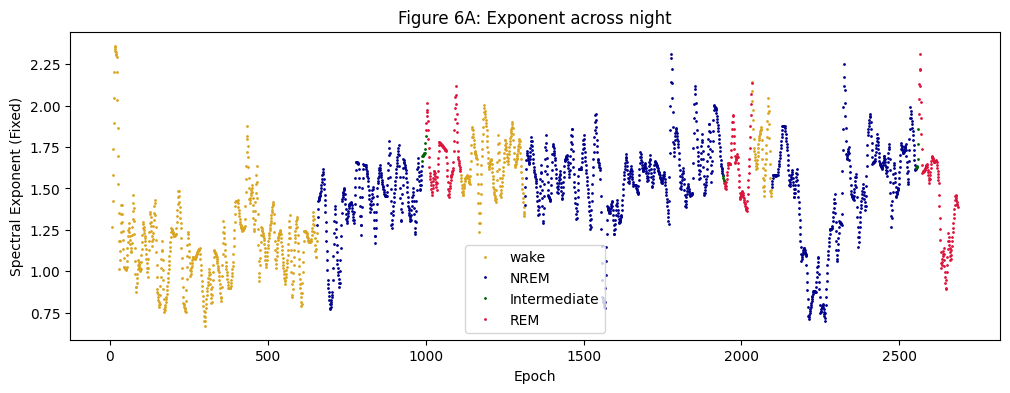

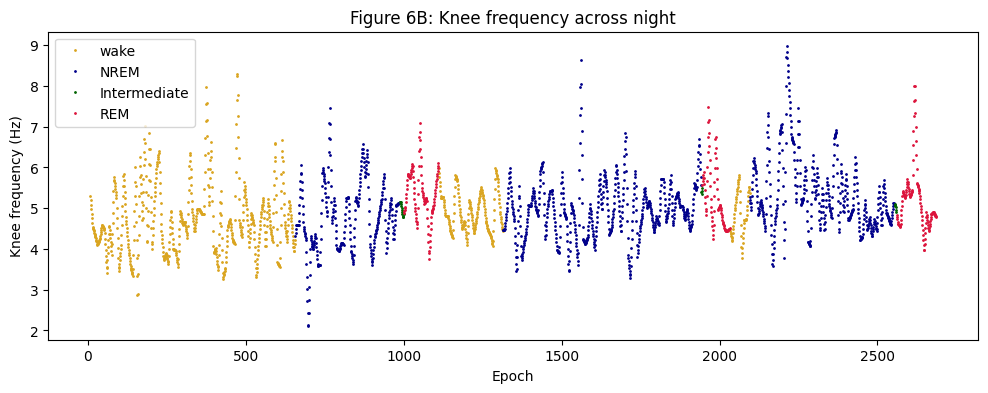

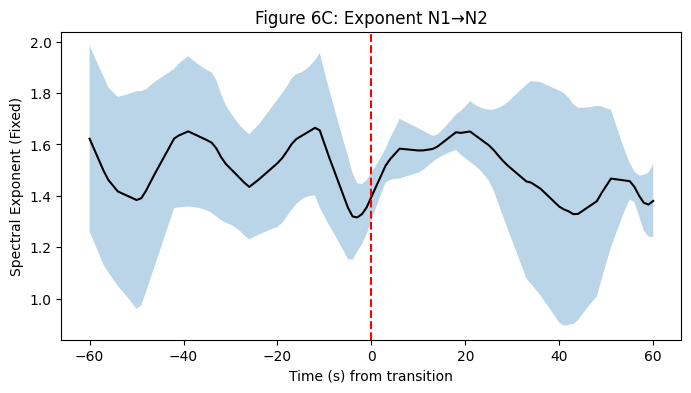

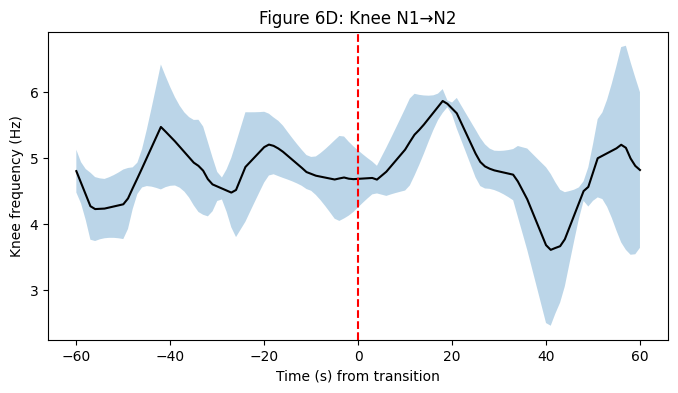

No transitions found for Figure 6C: Exponent NREM→REM
No transitions found for Figure 6D: Knee NREM→REM


/tmp/ipython-input-1822461479.py:124: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Stage', y='R2 Fixed', palette='colorblind')


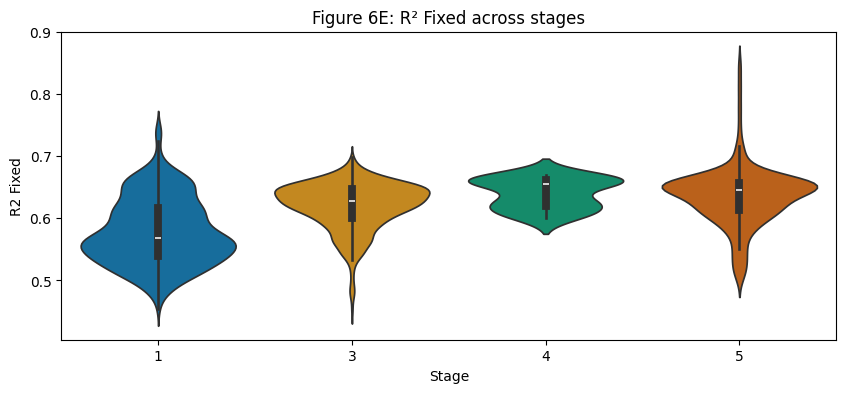

/tmp/ipython-input-1822461479.py:129: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Stage', y='R2 Knee', palette='colorblind')


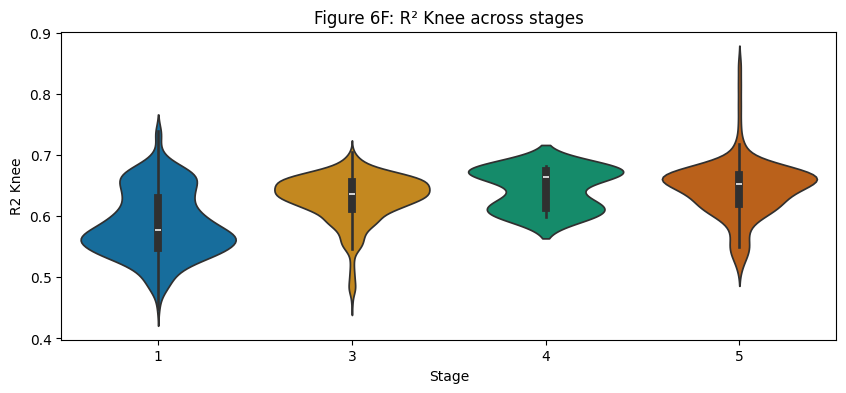

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from fooof import FOOOF
from scipy.signal import welch
from scipy.interpolate import interp1d
from scipy.io import loadmat
import seaborn as sns
import pandas as pd

# --- SETTINGS ---
fs = 2500  # Hz
win_sec = 15
overlap = 0.5
f_range = [1, 45]
max_n_peaks = 8

win_samp = int(win_sec * fs)
step_samp = int(win_samp * (1 - overlap))

# --- LOAD DATA ---
signal = loadmat('/content/HPC_100_CH18_0.continuous.mat')['HPC'].squeeze()
stages = loadmat('/content/2021-06-18_13-09-53_posttrial4-states_SM.mat')['states'].squeeze()

# --- SLIDING FOOOF ---
n_win = (len(signal) - win_samp) // step_samp
exp_fixed, exp_knee, knee_freq, r2_fixed, r2_knee, times = [], [], [], [], [], []

for i in range(n_win):
    start = i * step_samp
    seg = signal[start:start + win_samp]
    freqs, psd = welch(seg, fs=fs, nperseg=win_samp)
    mask = (freqs >= f_range[0]) & (freqs <= f_range[1])

    # Fixed
    fm_f = FOOOF(max_n_peaks=max_n_peaks, aperiodic_mode='fixed')
    fm_f.fit(freqs[mask], psd[mask])
    exp_fixed.append(fm_f.aperiodic_params_[1])
    r2_fixed.append(fm_f.r_squared_)

    # Knee
    fm_k = FOOOF(max_n_peaks=max_n_peaks, aperiodic_mode='knee')
    fm_k.fit(freqs[mask], psd[mask])
    exp_knee.append(fm_k.aperiodic_params_[1])
    knee_freq.append(fm_k.aperiodic_params_[0])
    r2_knee.append(fm_k.r_squared_)

    times.append((start + win_samp // 2) / fs)

# --- INTERPOLATE TO EPOCHS ---
epoch_times = np.arange(len(stages))
interp_fixed = interp1d(times, exp_fixed, bounds_error=False, fill_value=np.nan)
interp_knee = interp1d(times, exp_knee, bounds_error=False, fill_value=np.nan)
interp_knee_freq = interp1d(times, knee_freq, bounds_error=False, fill_value=np.nan)
interp_r2_fixed = interp1d(times, r2_fixed, bounds_error=False, fill_value=np.nan)
interp_r2_knee = interp1d(times, r2_knee, bounds_error=False, fill_value=np.nan)

exp_fixed_ep = interp_fixed(epoch_times)
exp_knee_ep = interp_knee(epoch_times)
knee_freq_ep = interp_knee_freq(epoch_times)
r2_fixed_ep = interp_r2_fixed(epoch_times)
r2_knee_ep = interp_r2_knee(epoch_times)

# --- PLOTS FIG 6A+B ---
plt.figure(figsize=(12, 4))
for s, label, color in zip([1, 3, 4, 5], ['wake','NREM','Intermediate','REM'], ['goldenrod', 'darkblue', 'darkgreen', 'crimson']):
    idx = stages == s
    plt.plot(epoch_times[idx], exp_fixed_ep[idx], '.', color=color, markersize=2, label=label)
plt.xlabel('Epoch')
plt.ylabel('Spectral Exponent (Fixed)')
plt.legend()
plt.title('Figure 6A: Exponent across night')
plt.show()

plt.figure(figsize=(12, 4))
for s, label, color in zip([1, 3, 4, 5], ['wake','NREM','Intermediate','REM'], ['goldenrod', 'darkblue', 'darkgreen', 'crimson']):
    idx = stages == s
    plt.plot(epoch_times[idx], knee_freq_ep[idx], '.', color=color, markersize=2, label=label)
plt.xlabel('Epoch')
plt.ylabel('Knee frequency (Hz)')
plt.legend()
plt.title('Figure 6B: Knee frequency across night')
plt.show()

# --- TRANSITION PLOTS FIG 6C+D ---
def plot_transition(data, stages, trans_from, trans_to, title, ylabel):
    trans_idx = np.where((stages[:-1] == trans_from) & (stages[1:] == trans_to))[0] + 1
    t_axis = np.arange(-60, 61)
    segments = []
    for t in trans_idx:
        t_range = t_axis + t
        valid = (t_range >= 0) & (t_range < len(data))
        seg = np.full_like(t_axis, np.nan, dtype=float)
        seg[valid] = data[t_range[valid]]
        segments.append(seg)
    if not segments:
        print(f"No transitions found for {title}")
        return
    segments = np.array(segments)
    mean = np.nanmean(segments, axis=0)
    std = np.nanstd(segments, axis=0)

    plt.figure(figsize=(8, 4))
    plt.plot(t_axis, mean, label=title, color='black')
    plt.fill_between(t_axis, mean - std, mean + std, alpha=0.3)
    plt.axvline(0, color='red', linestyle='--')
    plt.xlabel('Time (s) from transition')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

plot_transition(exp_fixed_ep, stages, 1, 3, 'Figure 6C: Exponent N1→N2', 'Spectral Exponent (Fixed)')
plot_transition(knee_freq_ep, stages, 1, 3, 'Figure 6D: Knee N1→N2', 'Knee frequency (Hz)')
plot_transition(exp_fixed_ep, stages, 3, 5, 'Figure 6C: Exponent NREM→REM', 'Spectral Exponent (Fixed)')
plot_transition(knee_freq_ep, stages, 3, 5, 'Figure 6D: Knee NREM→REM', 'Knee frequency (Hz)')

# --- FIG 6E + F R² ACROSS STAGES ---
df = pd.DataFrame({
    'Stage': stages,
    'R2 Fixed': r2_fixed_ep,
    'R2 Knee': r2_knee_ep
})

plt.figure(figsize=(10,4))
sns.violinplot(data=df, x='Stage', y='R2 Fixed', palette='colorblind')
plt.title('Figure 6E: R² Fixed across stages')
plt.show()

plt.figure(figsize=(10,4))
sns.violinplot(data=df, x='Stage', y='R2 Knee', palette='colorblind')
plt.title('Figure 6F: R² Knee across stages')
plt.show()
